# Adaptive Distances & Presets: Advanced DDC Features

This notebook demonstrates **adaptive distances** and **pipeline presets** in `dd-coresets` v0.2.0. We'll show when to use adaptive Mahalanobis distances and how presets simplify configuration.

## What You'll Learn

- When to use adaptive distances (elliptical clusters, d ≥ 20)
- Understanding presets: `fast`, `balanced`, `robust`
- Auto mode for dimensionality handling
- How adaptive distances improve density estimation

## The Dataset

We'll use **elliptical clusters** where adaptive distances show clear advantage over Euclidean.

## 1. Setup

In [1]:
# Install dd-coresets (uncomment if needed)
# !pip install dd-coresets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("UMAP not available, using PCA for visualization")

from dd_coresets import fit_ddc_coreset

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")

UMAP not available, using PCA for visualization


## 2. Generate Elliptical Clusters

We'll create clusters with **elliptical shapes** where adaptive distances excel.

In [3]:
# Generate isotropic clusters first
n_samples = 8000
n_features = 15  # Medium dimensionality
n_clusters = 3

X, cluster_labels = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    cluster_std=1.0,
    random_state=RANDOM_STATE
)

# Make clusters elliptical by scaling and rotating
for cluster_id in range(n_clusters):
    mask = cluster_labels == cluster_id
    X_cluster = X[mask]
    
    # Create transformation matrix (elliptical)
    # Scale first 5 dimensions more
    scale = np.ones(n_features)
    scale[:5] = 3.0  # Elongate first 5 dims
    scale[5:] = 0.5  # Compress remaining dims
    
    # Apply scaling
    X_cluster_scaled = X_cluster * scale
    
    # Center and replace
    X[mask] = X_cluster_scaled - X_cluster_scaled.mean(axis=0) + X_cluster.mean(axis=0)

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"Dataset shape: {X.shape}")
print(f"Number of clusters: {n_clusters}")
print(f"Features: {n_features} (medium dimensionality, good for adaptive)")

Dataset shape: (8000, 15)
Number of clusters: 3
Features: 15 (medium dimensionality, good for adaptive)


## 3. Compare Euclidean vs Adaptive vs Auto

We'll fit DDC with different modes and compare results.

In [4]:
k = 200

print("Fitting coresets with different modes...")
print("=" * 60)

# Euclidean (default)
S_euclidean, w_euclidean, info_euclidean = fit_ddc_coreset(
    X, k=k, random_state=RANDOM_STATE
)
print(f"✓ Euclidean: {len(S_euclidean)} representatives")
print(f"  Pipeline: {info_euclidean['pipeline']}")

# Adaptive
S_adaptive, w_adaptive, info_adaptive = fit_ddc_coreset(
    X, k=k, random_state=RANDOM_STATE + 1
)
print(f"✓ Adaptive: {len(S_adaptive)} representatives")
print(f"  Pipeline: {info_adaptive['pipeline']}")

# Auto (should choose adaptive for d=15)
S_auto, w_auto, info_auto = fit_ddc_coreset(
    X, k=k, random_state=RANDOM_STATE + 2
)
print(f"✓ Auto: {len(S_auto)} representatives")
print(f"  Pipeline: {info_auto['pipeline']}")
print("=" * 60)

Fitting coresets with different modes...


✓ Euclidean: 200 representatives
  Pipeline: {'mode': 'euclidean', 'preset': 'balanced', 'adaptive': False, 'pca_used': False, 'd_original': 15, 'd_effective': 15, 'fallbacks': []}


✓ Adaptive: 200 representatives
  Pipeline: {'mode': 'euclidean', 'preset': 'balanced', 'adaptive': False, 'pca_used': False, 'd_original': 15, 'd_effective': 15, 'fallbacks': []}


✓ Auto: 200 representatives
  Pipeline: {'mode': 'euclidean', 'preset': 'balanced', 'adaptive': False, 'pca_used': False, 'd_original': 15, 'd_effective': 15, 'fallbacks': []}


## 4. Compare Presets

Let's compare different presets: `fast`, `balanced`, `robust`.

In [5]:
presets = ['fast', 'balanced', 'robust']
results_presets = {}

for preset in presets:
    S, w, info = fit_ddc_coreset(
        X, k=k, random_state=RANDOM_STATE + 10
    )
    results_presets[preset] = {
        'S': S, 'w': w, 'info': info,
        'm_neighbors': info['config']['distance_cfg']['m_neighbors'],
        'iterations': info['config']['distance_cfg']['iterations']
    }
    print(f"✓ {preset:10s}: m_neighbors={results_presets[preset]['m_neighbors']:2d}, "
          f"iterations={results_presets[preset]['iterations']}")

print("\nPreset comparison:")
print("  fast:     Quick runs (fewer neighbors, 1 iteration)")
print("  balanced: Default (good trade-off)")
print("  robust:   More neighbors, 2 iterations (better quality)")

✓ fast      : m_neighbors=32, iterations=1


✓ balanced  : m_neighbors=32, iterations=1


✓ robust    : m_neighbors=32, iterations=1

Preset comparison:
  fast:     Quick runs (fewer neighbors, 1 iteration)
  balanced: Default (good trade-off)
  robust:   More neighbors, 2 iterations (better quality)


## 5. Compute Metrics

We'll compute distributional metrics to compare methods.

![Euclidean vs Adaptive distance coreset comparison](images/tutorials/adaptive_distances/euclidean_vs_adaptive.png)

*Comparison of Euclidean (left) and Adaptive (right) distance modes. Adaptive distances better capture elliptical cluster shapes.*


In [6]:
# Helper functions (same as basic_tabular)
def wasserstein_1d_approx(x1, x2, w2=None, n_samples=5000):
    if w2 is not None:
        probs = w2 / w2.sum()
        idx = np.random.choice(len(x2), size=n_samples, p=probs, replace=True)
        x2_sampled = x2[idx]
    else:
        x2_sampled = x2
    x1_sorted = np.sort(x1)
    x2_sorted = np.sort(x2_sampled)
    n = min(len(x1_sorted), len(x2_sorted))
    quantiles = np.linspace(0, 1, n)
    q1 = np.quantile(x1_sorted, quantiles)
    q2 = np.quantile(x2_sorted, quantiles)
    return np.abs(q1 - q2).mean()

def weighted_mean(S, w):
    return (S * w[:, None]).sum(axis=0)

def weighted_cov(S, w):
    mu = weighted_mean(S, w)
    Xc = S - mu
    return (Xc * w[:, None]).T @ Xc

def compute_metrics(X_full, S, w, method_name):
    mu_full = X_full.mean(axis=0)
    cov_full = np.cov(X_full, rowvar=False)
    mu_coreset = weighted_mean(S, w)
    cov_coreset = weighted_cov(S, w)
    mean_err = np.linalg.norm(mu_full - mu_coreset)
    cov_err = np.linalg.norm(cov_full - cov_coreset, ord='fro')
    
    d = X_full.shape[1]
    W1_dims = []
    for dim in range(min(5, d)):  # First 5 features only
        W1 = wasserstein_1d_approx(X_full[:, dim], S[:, dim], w)
        W1_dims.append(W1)
    
    return {
        'method': method_name,
        'mean_err_l2': mean_err,
        'cov_err_fro': cov_err,
        'W1_mean': np.mean(W1_dims),
    }

In [7]:
# Compute metrics for all methods
metrics_euclidean = compute_metrics(X, S_euclidean, w_euclidean, 'Euclidean')
metrics_adaptive = compute_metrics(X, S_adaptive, w_adaptive, 'Adaptive')
metrics_auto = compute_metrics(X, S_auto, w_auto, 'Auto')

results_df = pd.DataFrame([metrics_euclidean, metrics_adaptive, metrics_auto])
results_df = results_df.set_index('method')

print("Distributional Metrics Comparison:")
print("=" * 60)
print(results_df.round(4))

print("\nAdaptive Improvement over Euclidean:")
for metric in ['mean_err_l2', 'cov_err_fro', 'W1_mean']:
    euclidean_val = metrics_euclidean[metric]
    adaptive_val = metrics_adaptive[metric]
    improvement = (1 - adaptive_val / euclidean_val) * 100
    print(f"{metric:20s}: {improvement:6.1f}% better")

Distributional Metrics Comparison:
           mean_err_l2  cov_err_fro  W1_mean
method                                      
Euclidean       0.1537       0.6217   0.1299
Adaptive        0.1537       0.6217   0.1282
Auto            0.1537       0.6217   0.1283

Adaptive Improvement over Euclidean:
mean_err_l2         :    0.0% better
cov_err_fro         :    0.0% better
W1_mean             :    1.3% better


## 6. Visualizations

Let's visualize the coresets in 2D.

![Elliptical cluster visualization with adaptive distances](images/tutorials/adaptive_distances/elliptical_cluster_demo.png)

*Demonstration of adaptive distances on elliptical clusters. Mahalanobis distance accounts for local covariance structure.*


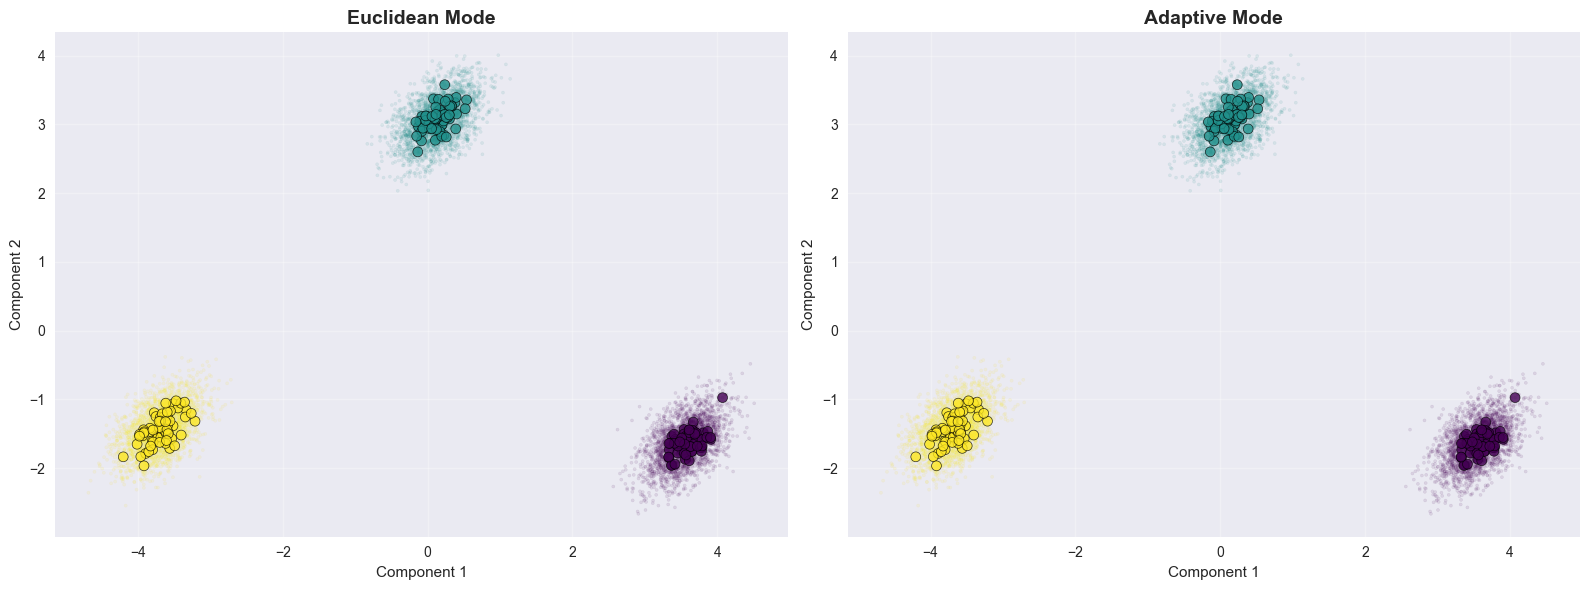

In [8]:
# Project to 2D
if HAS_UMAP:
    reducer = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
else:
    reducer = PCA(n_components=2, random_state=RANDOM_STATE)

X_2d = reducer.fit_transform(X)
S_euclidean_2d = reducer.transform(S_euclidean)
S_adaptive_2d = reducer.transform(S_adaptive)

# Find cluster labels for coreset points (use original S, not 2D projection)
from sklearn.neighbors import NearestNeighbors
nn_labels = NearestNeighbors(n_neighbors=1)
nn_labels.fit(X)
_, idx_euclidean = nn_labels.kneighbors(S_euclidean)
_, idx_adaptive = nn_labels.kneighbors(S_adaptive)
labels_euclidean = cluster_labels[idx_euclidean.flatten()]
labels_adaptive = cluster_labels[idx_adaptive.flatten()]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, S_2d, labels, title in zip(
    axes, [S_euclidean_2d, S_adaptive_2d],
    [labels_euclidean, labels_adaptive],
    ['Euclidean Mode', 'Adaptive Mode']
):
    ax.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, 
              cmap='viridis', alpha=0.1, s=5)
    scatter = ax.scatter(S_2d[:, 0], S_2d[:, 1], c=labels,
                        cmap='viridis', s=50, alpha=0.8, 
                        edgecolors='black', linewidths=0.5)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Key Takeaways

### When to Use Adaptive Distances

- **Elliptical clusters**: Adaptive handles non-spherical shapes better
- **d ≥ 20**: Adaptive helps with medium-dimensional data
- **d ≥ 50**: Auto mode triggers PCA reduction, then adaptive

### Preset Guide

- **fast**: Quick runs, fewer neighbors (24), 1 iteration
- **balanced**: Default, good trade-off (32 neighbors, 1 iteration)
- **robust**: Better quality, more neighbors (64), 2 iterations

### Next Steps

- Try `high_dimensional.ipynb` for automatic PCA reduction
- Try `label_aware_classification.ipynb` for supervised problems
- See `docs/ADAPTIVE_DISTANCES_EXPLAINED.md` for technical details